In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
# This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.
import pickle 
import gzip

#This converts the Path object into a string in POSIX format (i.e., uses forward slashes / as separators).
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    

In [3]:
from matplotlib import pyplot as plt
import numpy as np

(50000, 784)


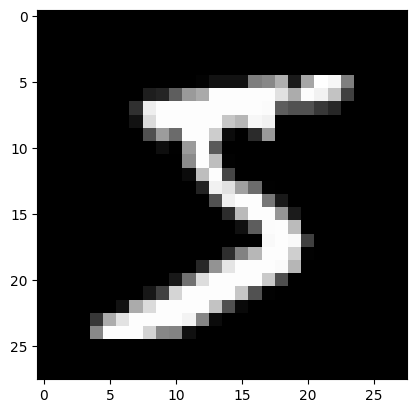

In [4]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

In [36]:
import torch

x_train, y_train, x_valid, y_valid = map(
    lambda x: x.detach().clone(), (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (without torch.nn)

In [60]:
import math 

weights = torch.rand(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [61]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

def model(xb):
    return log_softmax(xb @ weights + bias)

In [62]:
bs = 64 # batch size 

xb = x_train[:bs].float()
preds = model(xb)
preds[0], preds.shape

(tensor([-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [97]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()
    


In [98]:
loss_func = nll

yb = y_train[:bs]
print(loss_func(preds, yb))


tensor(2.3026, grad_fn=<NegBackward0>)


In [99]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [100]:
accuracy(preds, yb)

tensor(0.1094)

In [103]:
lr = 1
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1): # This is a math trick to simulate math.ceil(n / bs) without importing math
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i].float()
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()


In [104]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(2.2851, grad_fn=<NegBackward0>), tensor(0.1875))

# Using torch.nn.functional

In [122]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [123]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

RuntimeError: expected m1 and m2 to have the same dtype, but got: __int64 != float

### Refactor using nn.Module

In [159]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(784, 10,  dtype=torch.float) / math.sqrt(784), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(10,  dtype=torch.float), requires_grad=True)

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [141]:
model = Mnist_Logistic()
xb = xb.float()
loss_func(model(xb), yb)

tensor(2.3026, grad_fn=<NllLossBackward0>)

In [142]:

print(loss_func(model(xb), yb))

tensor(2.3026, grad_fn=<NllLossBackward0>)


### Refactor using torch.optim

In [143]:
from torch import optim 

In [144]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i].float()
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))



tensor(2.3026, grad_fn=<NllLossBackward0>)
tensor(2.2851, grad_fn=<NllLossBackward0>)


### Refactor using Dataset

#### Previously, we had to iterate through minibatches of x and y values separately:
- xb = x_train[start_i:end_i]
- yb = y_train[start_i:end_i]

#### Now, we can do these two steps together:
- from torch.utils.data import TensorDataset
- train_ds = TensorDataset(x_train, y_train)
- xb,yb = train_ds[i*bs : i*bs+bs]

In [149]:
from torch.utils.data import TensorDataset

In [156]:
train_ds = TensorDataset(x_train, y_train)

In [161]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb.float())
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb.float()), yb))

tensor(2.2851, grad_fn=<NllLossBackward0>)


### Refactor using DataLoader


In [162]:
from torch.utils.data import DataLoader 

In [163]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [164]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb.float())
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb.float()), yb))

tensor(2.2851, grad_fn=<NllLossBackward0>)
